# IMDB Movie Review Sentiment Analysis

## 1. Problem and Motivation

Sentiment analysis of movie reviews helps movie studios, streaming platforms, and researchers understand audience sentiment at scale. This enables data-driven decision-making for marketing, content recommendations, and product improvements. Automated text analysis is crucial for processing thousands of reviews, which would be infeasible to analyze manually.

## 2. Dataset Description

- **Name:** IMDB Dataset of 50K Movie Reviews
- **Source:** [Kaggle: lakshmi25npathi/imdb-dataset-of-50k-movie-reviews](https://www.kaggle.com/datasets/lakshmi25npathi/imdb-dataset-of-50k-movie-reviews)
- **Rows:** 50,000
- **Columns:**
    - `review`: The text of the review
    - `sentiment`: Label (positive/negative)
- **Data Types:**
    - `review`: string (text)
    - `sentiment`: categorical
- **Missingness:** No missing values in either column
- **Sensitive Attributes:** Reviews may contain personal opinions and references to individuals

### Loading the Dataset

We'll use the `kagglehub` library as specified:

In [1]:
 
# import kagglehub

#  # Download the latest version 
# path = kagglehub.dataset_download("lakshmi25npathi/imdb-dataset-of-50k-movie-reviews")

# print("Path to dataset files:", path)


In [2]:
path = 'C:\\Users\\User\\.cache\\kagglehub\\datasets\\lakshmi25npathi\\imdb-dataset-of-50k-movie-reviews\\versions\\1'

In [3]:
import pandas as pd

# Assuming it's a CSV file, you can load it like this:
df = pd.read_csv(path + "/IMDB Dataset.csv")
df.head()


,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [4]:
df.describe()

,review,sentiment
count,50000,50000
unique,49582,2
top,Loved today's show!!! It was a variety and not...,positive
freq,5,25000


In [5]:
# Seeing the whole dataset and number of rows and columns
print(df.shape)
df

(50000, 2)


,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive
...,...,...
49995,I thought this movie did a down right good job...,positive
49996,"Bad plot, bad dialogue, bad acting, idiotic di...",negative
49997,I am a Catholic taught in parochial elementary...,negative
49998,I'm going to have to disagree with the previou...,negative


In [6]:
# 📋 Summary of the DataFrame — shows column names, data types, non-null values, and memory usage
df.info()
# 🧮 Calculate the total number of missing (NaN) values for each column in the DataFrame
missing_counts = df.isnull().sum()

# 🖨️ Print a summary showing how many missing values exist in each column
print("Missing values in each column:")
missing_counts

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     50000 non-null  object
 1   sentiment  50000 non-null  object
dtypes: object(2)
memory usage: 781.4+ KB
Missing values in each column:


review       0
sentiment    0
dtype: int64

In [7]:
# examine the class distribution
df.sentiment.value_counts()

sentiment
positive    25000
negative    25000
Name: count, dtype: int64

## EDA

### searching for duplicates

In [8]:
duplicated = df.duplicated()


print(f"Number of duplicated rows: {duplicated.sum()}")

# Remove duplicates
#df = df.drop_duplicates()

Number of duplicated rows: 418


### removing the duplicates

In [9]:
# Remove duplicates
df = df.drop_duplicates()

# Check again for duplicates
duplicated = df.duplicated()

print(f"Number of duplicated rows: {duplicated.sum()}")

Number of duplicated rows: 0


### Plot 1 – Target distribution plot for classification (bar plot of class counts).

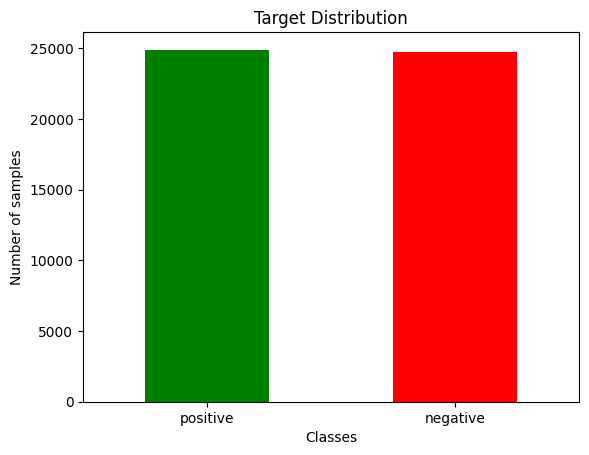

In [10]:
#!pip install matplotlib
#!pip install seaborn

import matplotlib.pyplot as plt
import seaborn as sns


x = df.review
y = df.sentiment
target_plot = y.value_counts().plot(kind='bar', title='Target Distribution', xlabel='Classes', ylabel='Number of samples', color=['green', 'red'])
target_plot.set_xticklabels(target_plot.get_xticklabels(), rotation=0)
plt.show()


###  Plot 2 – Correlation heatmap or boxplot summary for key numeric features.


## Classification ML

### Train-Validation-Test Split + LR Model

In [ ]:
#!pip install scikit-learn

# train validation test split (60% train, 20% validation, 20% test)
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
import numpy as np

# First split: separate out test set (20%)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42, stratify=y)

# Create a pipeline
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('clf', LogisticRegression())
])

# cross-validation on training set (with 5 folds)
cv_scores = cross_val_score(pipeline, x_train, y_train, cv=5, scoring='accuracy')

# Print cross-validation scores and mean scores
print(f"Cross-validation scores: {cv_scores}")
print(f"Mean CV accuracy: {np.mean(cv_scores):.4f}")

# Train final model on full training+validation set
pipeline.fit(x_train, y_train)

# Step 5: Evaluate on test set
test_accuracy = pipeline.score(x_test, y_test)
print(f"Test set accuracy: {test_accuracy:.4f}")

Cross-validation scores: [0.89537376 0.89499559 0.89348292 0.88957519 0.89108786]
Mean CV accuracy: 0.8929
Test set accuracy: 0.8971


### Learning Curve

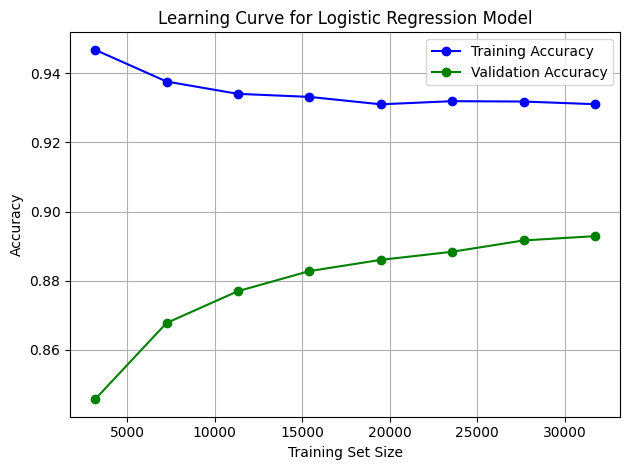

In [13]:
from sklearn.model_selection import learning_curve
import matplotlib.pyplot as plt
import numpy as np


train_sizes, train_scores, val_scores = learning_curve(
    pipeline, x_train, y_train,
    cv=5,
    train_sizes=np.linspace(0.1, 1.0, 8),
    scoring='accuracy',
    shuffle=True,
    random_state=42,
    n_jobs=-1
)

train_mean = np.mean(train_scores, axis=1)
val_mean = np.mean(val_scores, axis=1)

plt.plot(train_sizes, train_mean, 'o-', color='blue', label='Training Accuracy')
plt.plot(train_sizes, val_mean, 'o-', color='green', label='Validation Accuracy')
plt.xlabel('Training Set Size')
plt.ylabel('Accuracy')
plt.title('Learning Curve for Logistic Regression Model')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


### Improve the model

In [14]:
from sklearn.model_selection import GridSearchCV

# Define parameter grid
param_grid = {
    'tfidf__ngram_range': [(1,1), (1,2)],
    'tfidf__max_df': [0.75, 1.0],
    'tfidf__min_df': [1, 5],
    'clf__C': [0.01, 0.1, 1, 10],
    'clf__penalty': ['l2'],  # 'l1' requires solver='liblinear'
}

# Create pipeline with compatible solver
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('clf', LogisticRegression(solver='liblinear'))
])

# Run grid search with cross-validation
grid = GridSearchCV(
    pipeline,
    param_grid,
    cv=5,
    scoring='accuracy',
    n_jobs=-1,
    verbose=1
)

# Fit on training data
grid.fit(x_train, y_train)

# Show best parameters and score
print("Best Parameters:", grid.best_params_)
print(f"Best Cross-Validation Accuracy: {grid.best_score_:.4f}")

# Evaluate best model on test set
best_model = grid.best_estimator_
test_accuracy = best_model.score(x_test, y_test)
print(f"Test Set Accuracy with Best Model: {test_accuracy:.4f}")


Fitting 5 folds for each of 32 candidates, totalling 160 fits


KeyboardInterrupt: 